In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Induction


/content/gdrive/MyDrive/Induction


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Induction"

In [ ]:
!kaggle datasets download -d uysalserkan/fault-induction-motor-dataset

In [ ]:
!unzip /content/gdrive/MyDrive/Induction/fault-induction-motor-dataset.zip

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
from scipy import stats
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow.keras.backend as K
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, add, concatenate, Lambda, Flatten
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras import regularizers
import tensorflow.keras as keras 
import tensorflow as tf
import numpy as np 
import cv2 
import os 
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
svc = SVC(probability=True, gamma="auto")
from keras.wrappers.scikit_learn import KerasClassifier


In [3]:
normal_file_names = glob.glob("/content/gdrive/MyDrive/Induction/normal/normal/*.csv")
imnormal_file_names_6g = glob.glob("/content/gdrive/MyDrive/Induction/imbalance/imbalance/6g/*.csv")
imnormal_file_names_10g = glob.glob("/content/gdrive/MyDrive/Induction/imbalance/imbalance/10g/*.csv")
imnormal_file_names_15g = glob.glob("/content/gdrive/MyDrive/Induction/imbalance/imbalance/15g/*.csv")
imnormal_file_names_20g = glob.glob("/content/gdrive/MyDrive/Induction/imbalance/imbalance/20g/*.csv")
imnormal_file_names_25g = glob.glob("/content/gdrive/MyDrive/Induction/imbalance/imbalance/25g/*.csv")
imnormal_file_names_30g = glob.glob("/content/gdrive/MyDrive/Induction/imbalance/imbalance/30g/*.csv")
imnormal_file_names_35g = glob.glob("/content/gdrive/MyDrive/Induction/imbalance/imbalance/35g/*.csv")

In [4]:
def dataReader(path_names):
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i,header=None)
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

In [5]:
data_n = dataReader(normal_file_names)
data_6g = dataReader(imnormal_file_names_6g)
data_10g = dataReader(imnormal_file_names_10g)
data_15g = dataReader(imnormal_file_names_15g)
data_20g = dataReader(imnormal_file_names_20g)
data_25g = dataReader(imnormal_file_names_25g)
data_30g = dataReader(imnormal_file_names_30g)
data_35g = dataReader(imnormal_file_names_35g)

In [ ]:
data_n.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12250000 entries, 0 to 12249999
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
dtypes: float64(8)
memory usage: 747.7 MB


In [ ]:
print(data_n.shape)
print(data_6g.shape)

(12250000, 8)
(12250000, 8)


In [6]:
def downSampler(data,a,b):
    """
    data = data
    a = start index
    b = sampling rate
    """
    data_decreased = pd.DataFrame()
    x = b
    for i in range(int(len(data)/x)):
        data_decreased = data_decreased.append(data.iloc[a:b,:].sum()/x,ignore_index=True)
        a += x
        b += x
    return data_decreased

In [7]:
data_n = downSampler(data_n, 0, 300)
data_6g = downSampler(data_6g, 0, 300)
data_10g = downSampler(data_10g, 0, 300)
data_15g = downSampler(data_15g, 0, 300)
data_20g = downSampler(data_20g, 0, 300)
data_25g = downSampler(data_25g, 0, 300)
data_30g = downSampler(data_30g, 0, 300)
data_35g = downSampler(data_35g, 0, 300)

In [ ]:
data_n.shape

(40833, 8)

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,15))
fig.suptitle('All Features of Normal State')
for i in data_n.columns:
    axs[i].plot(data_n[i])
    axs[i].set_title('{} Column of Dataset'.format(i))

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,15))
fig.suptitle('All Features of Normal State')
for i in data_6g.columns:
    axs[i].plot(data_n[i])
    axs[i].set_title('{} Column of Anormal State'.format(i))

In [8]:
from scipy import signal
def FFT(data):
    autocorr = signal.fftconvolve(data,data[::-1],mode='full')
    return pd.DataFrame(autocorr)

In [9]:
data_n = FFT(data_n)
data_6g = FFT(data_6g)
data_10g = FFT(data_10g)
data_15g = FFT(data_15g)
data_20g = FFT(data_20g)
data_25g = FFT(data_25g)
data_30g = FFT(data_30g)
data_35g = FFT(data_35g)

In [ ]:
y_1 = pd.DataFrame(np.ones(int(len(data_n)),dtype=int))
y_2 = pd.DataFrame(np.zeros(int(len(data_6g)),dtype=int))
y_3 = pd.DataFrame(np.full((int(len(data_10g)),1),2))
y_4 = pd.DataFrame(np.full((int(len(data_15g)),1),3))
y_5 = pd.DataFrame(np.full((int(len(data_20g)),1),4))
y_6 = pd.DataFrame(np.full((int(len(data_25g)),1),5))
y_7 = pd.DataFrame(np.full((int(len(data_30g)),1),6))
y_8 = pd.DataFrame(np.full((int(len(data_35g)),1),7))

y = pd.concat([y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8], ignore_index=True)
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)


In [ ]:
data = pd.concat([data_n,data_6g,data_10g,data_15g,data_20g,data_25g,data_30g,data_35g],ignore_index=True)
data

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,y, test_size=0.3, shuffle=True)

In [25]:
checkpoint=keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=1, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

reduce_LOP=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=0.001)
Callbacks=[checkpoint,reduce_LOP]

In [26]:
def create_model():
  model = Sequential()
  model.add(Dense(32, activation='LeakyReLU', input_shape=(15,),kernel_initializer='random_uniform'))
  model.add(Dense(64, activation='LeakyReLU',kernel_initializer='random_uniform'))
  model.add(Dense(128, activation='LeakyReLU',kernel_initializer='random_uniform'))
  model.add(Dense(64, activation='LeakyReLU',kernel_initializer='random_uniform'))
  model.add(Dense(32, activation='LeakyReLU',kernel_initializer='random_uniform'))
  model.add(Dense(8, activation='softmax',kernel_initializer='random_uniform'))

  model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  return model

In [27]:
model=create_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 32)                512       
                                                                 
 dense_49 (Dense)            (None, 64)                2112      
                                                                 
 dense_50 (Dense)            (None, 128)               8320      
                                                                 
 dense_51 (Dense)            (None, 64)                8256      
                                                                 
 dense_52 (Dense)            (None, 32)                2080      
                                                                 
 dense_53 (Dense)            (None, 8)                 264       
                                                                 
Total params: 21,544
Trainable params: 21,544
Non-trai

In [28]:
#initialize random seeds so results are repeatable
import random
import tensorflow as tf

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
!pip install scikeras
from scikeras.wrappers import KerasClassifier

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=40, batch_size=128, verbose=1)
model._estimator_type = "classifier"

#self_training_model = SelfTrainingClassifier(model)
#history=model.fit(X_train, y_train, epochs=40, batch_size=128, verbose=1,validation_data=(X_test, y_test),callbacks=Callbacks)

In [ ]:
results1=model.predict(X_train)
results2=model.predict(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr', make_pipeline(
                           LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr', make_pipeline(
                           model))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

In [32]:
results1=clf.predict(X_train)
results2=clf.predict(X_test)

In [33]:
from sklearn.metrics import classification_report
LABELS = [
    'normal',
    'imbalance 6g',
    'imbalance 10g',
    'imbalance 15g',
    'imbalance 20g',
    'imbalance 25g',
    'imbalance 30g',
    'imbalance 35g',

]

print(classification_report(y_true = y_train, y_pred = results1,target_names=LABELS))
print(classification_report(y_true = y_test, y_pred = results2,target_names=LABELS))

               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     56940
 imbalance 6g       1.00      1.00      1.00     57112
imbalance 10g       1.00      1.00      1.00     56180
imbalance 15g       1.00      1.00      1.00     55992
imbalance 20g       1.00      1.00      1.00     57193
imbalance 25g       1.00      1.00      1.00     55023
imbalance 30g       1.00      1.00      1.00     54755
imbalance 35g       1.00      1.00      1.00     52462

     accuracy                           1.00    445657
    macro avg       1.00      1.00      1.00    445657
 weighted avg       1.00      1.00      1.00    445657

               precision    recall  f1-score   support

       normal       0.99      1.00      0.99     24725
 imbalance 6g       1.00      1.00      1.00     24553
imbalance 10g       1.00      1.00      1.00     23819
imbalance 15g       0.96      0.96      0.96     24007
imbalance 20g       0.96      0.96      0.96     24472
imbala

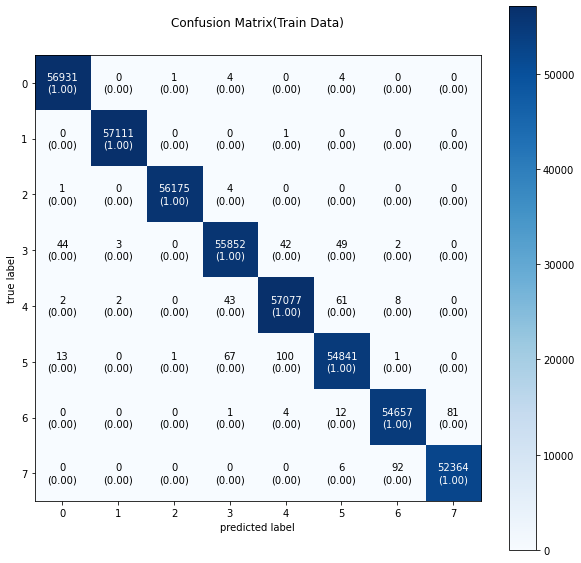

In [34]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

class_names = [
    'normal',
    'imbalance 6g',
    'imbalance 10g',
    'imbalance 15g',
    'imbalance 20g',
    'imbalance 25g',
    'imbalance 30g',
    'imbalance 35g',

]

conf_matrix = confusion_matrix(y_true = y_train, y_pred = results1)
binary1 = conf_matrix 

fig, ax = plot_confusion_matrix(conf_mat=binary1, figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                 )
plt.title('Confusion Matrix(Train Data)')

plt.show()



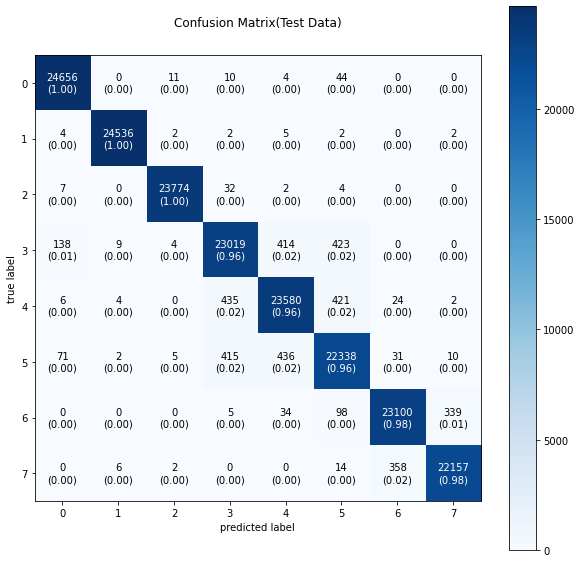

In [37]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = results2)
binary1 = conf_matrix 

fig, ax = plot_confusion_matrix(conf_mat=binary1,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                 )
plt.title('Confusion Matrix(Test Data)')
plt.show()